In [38]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from pandas import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
warnings.filterwarnings('ignore')

In [39]:
# Set the figure parameters
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

In [3]:
def is_stationary(ts, maxlag=15, autolag=None, regression='ct'):
    """Checks if the time series `ts` is stationary."""
    adf_result = adfuller(ts, maxlag=maxlag, autolag=autolag, regression=regression)
    return adf_result[0] < adf_result[4]['5%']

In [4]:
def d_param(ts, max_lag=12):
    """Finds out the differential order."""
    if is_stationary(ts):
        return 0

    d = -1
    for i in range(1, max_lag + 1):
        if is_stationary(ts.diff(i).dropna()):
            d = i         
    return d

In [5]:
def ARMA_params(ts, pmax=4, qmax=2, freq='M'):
    """
    Finds out the best AR order `p`, ma order `q` based on the time series `ts` for a ARMA model.
    
    Parameters
    ----------
    ts : array-like
        Time series data
    pmax : int
        The max value of AR order
    qmax : int
        The max value of ma order
    freq : str, optional
        The frequency of the time series. A Pandas offset or 'B', 'D', 'W',
        'M', 'A', or 'Q'. This is optional if dates are given.
        
    Returns
    -------
    p : int
        The best AR order
    q : int
        The best ma order
    """
    
    p_best = -1
    q_best = -1
    aic_best = float('inf')
    for p in range(pmax + 1):
        for q in range(qmax + 1):
            try:
                aic_cur = ARMA(ts, order=(p, q)).fit(freq=freq).aic
            except:
                continue
                
            if aic_cur < aic_best:
                p_best = p
                q_best = q
                aic_best = aic_cur
                
    return (p_best, q_best)

In [6]:
def ARIMA_params(ts, pmax=4, qmax=2, freq='M'):
    """
    Finds out the best AR order `p`, differential order `d` and ma order `q` 
    based on the time series `ts` for a ARIMA model.
    
    Parameters
    ----------
    ts : array-like
        Time series data
    pmax : int
        The max value of AR order
    qmax : int
        The max value of ma order
    freq : str, optional
        The frequency of the time series. A Pandas offset or 'B', 'D', 'W',
        'M', 'A', or 'Q'. This is optional if dates are given.
        
    Returns
    -------
    p : int
        The best AR order.
    d : int
        The best differential order.
    q : int
        The best ma order.
    """
    d = d_param(ts)
    
    p_best = -1
    q_best = -1
    aic_best = float('inf')
    for p in range(pmax + 1):
        for q in range(qmax + 1):
            try:
                aic_cur = ARIMA(ts, order=(p, d, q)).fit(freq=freq).aic
            except:
                continue
                
            if aic_cur < aic_best:
                p_best = p
                q_best = q
                aic_best = aic_cur
                
    return (p_best, d, q_best)

In [7]:
def diff(ts, order_num=1):
    """
    Returns the differenced series of the time series `ts` where the differential order is `order_num`.
    
    Parameters
    ----------
    ts : array-like
        Time series data
    order_num : int
        The differential order
        
    Returns
    -------
    ts_diff : array-like
        The differenced series.
    """
    ts_diff = list()
    for i in range(order_num, len(ts)):
        ts_diff.append(ts[i] - ts[i - order_num])
    return ts_diff

In [8]:
def inverse_diff(prev, ts, order_num=1):
    """
    Restore the differenced series `ts` based on the previous series `prev`
    where the differential order is `order_num`.
    
    Parameters
    ----------
    prev : array-like
        Previous time series
    ts : array-like
        The time series to restore
    order_num : int
        The differential order
        
    Returns
    -------
    res : array-like
        The restored time series
    """
    res = list()
    history = list(prev)
    for point in ts:
        value = point + history[-order_num]
        res.append(value)
        history.append(value)
    return res

In [9]:
def date_parser(x):
    month, year = x.split('-')
    return datetime.strptime('19' + year + '-' + month, '%Y-%b')

In [56]:
def error_prop(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [10]:
# Load data
data_path = "../data/monthly-car-sales-in-quebec-1960.csv"
df = pd.read_csv(data_path, index_col=['month'], parse_dates=['month'], squeeze=True, date_parser=date_parser)

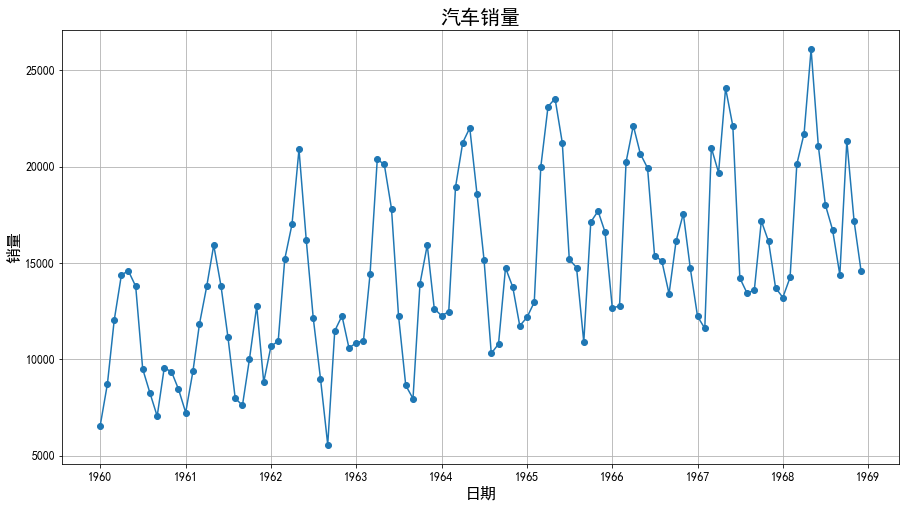

In [11]:
fig, ax = plt.subplots()
ax.plot(df, 'o-')
ax.set_xlabel('日期', fontsize=16)
ax.set_ylabel('销量', fontsize=16)
ax.set_title('汽车销量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [12]:
# order_num = 12
# df_diff = pd.Series(diff(df.values, order_num=order_num), index=df.index[order_num:])

In [13]:
# 对数据进行划分
train, test = df[:'1967'], df['1968':]

In [14]:
# 差分阶数
d = d_param(train)
print("The value of d is: %s" % d)

The value of d is: 10


In [15]:
# 差分后的序列
train_diff = pd.Series(diff(train, order_num=d), index=train.index[d:])

In [16]:
# AR阶数、MA阶数
p, q = ARMA_params(train_diff, pmax=20, qmax=20, freq='M')
print("The value of (p, q) is: (%s, %s)" % (p, q))

The value of (p, q) is: (16, 0)


In [18]:
# 训练模型
model = ARMA(train_diff, order=(p, q))
model_fit = model.fit(freq='M')

In [27]:
# 预测
preds_diff = model_fit.predict(start=test.index[0], end=test.index[-1])

In [31]:
# 还原预测值（逆差分）
preds = inverse_diff(train, preds_diff, order_num=d)
preds = pd.Series(preds, index=test.index)

In [45]:
rmse = sqrt(mean_squared_error(test, preds))
print("The RMSE of test set is:", rmse)

The RMSE of test set is: 2395.726008239232


In [43]:
error = error_prop(test, preds)
print("The error proportion of test set is:", error)

The error proportion of test set is: 0.00881867818761599


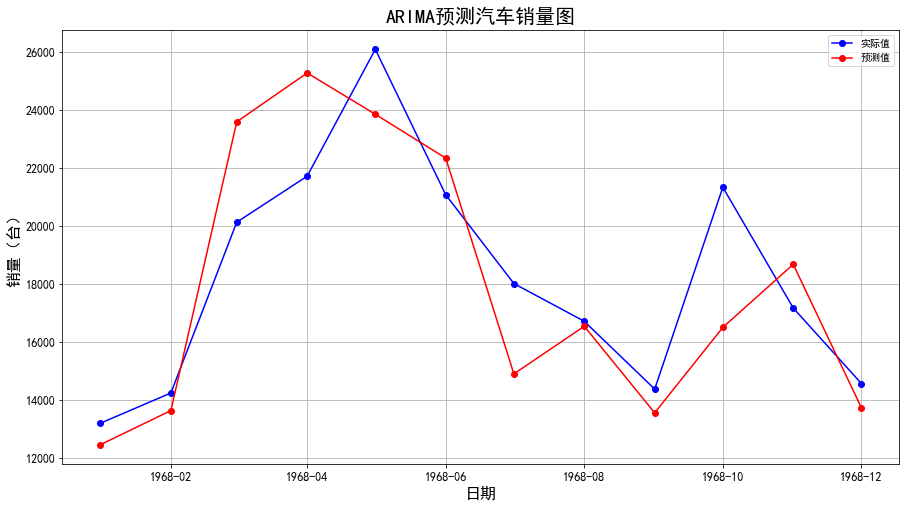

In [44]:
fig, ax = plt.subplots()
# ax.plot(train_day.index, train_day.order_num.values, 'go-', label='Train')
ax.plot(test, 'bo-', label='实际值')
ax.plot(preds, 'ro-', label='预测值')
ax.set_xlabel('日期', fontsize=16)
ax.set_ylabel('销量（台）', fontsize=16)
ax.set_title('ARIMA预测汽车销量图', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
# 分解时间序列
# decomposition_result = seasonal_decompose(df, model='additive')

In [ ]:
# plt.subplot(4, 1, 1)
# plt.plot(df, 'o-')
# plt.title('The time series')
# plt.ylabel('Sales')
# plt.grid(True)

# plt.subplot(4, 1, 2)
# plt.plot(decomposition_result.trend, 'o-')
# plt.title('The trend of the time series')
# # plt.ylabel('Sales')
# plt.grid(True)

# plt.subplot(4, 1, 3)
# plt.plot(decomposition_result.seasonal, 'o-')
# plt.title('The seasonal component of the time series')
# # plt.ylabel('Sales')
# plt.grid(True)

# plt.subplot(4, 1, 4)
# plt.plot(decomposition_result.resid, 'o-')
# plt.title('The residual component of the time series')
# # plt.ylabel('Sales')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [ ]:
# trend_comp = decomposition_result.trend
# seasonal_comp = decomposition_result.seasonal
# resid_comp = decomposition_result.resid